In [1]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor


from utils.data.model import VisionDataset
from utils.data.process import process_tensor, process_pil

In [2]:
data_path = Path('data')
class_map = {
    'cleaned': 0,
    'dirty': 1,
}

ds_train = VisionDataset(data_path, split='train', class_map=class_map, transform=process_pil)
ds_val = VisionDataset(data_path, split='validation', class_map=class_map, transform=process_pil)

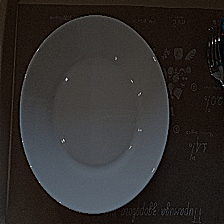

In [3]:
example = ds_train[1]['image']
example

In [4]:
# copy new images to train
# from pathlib import Path
# from utils.data.augment import copy
# for cls in ["cleaned", "dirty"]:
#     src_path = Path('data', 'new', cls)
#     target_path = Path('data', 'plates', 'train', cls)
#     copy(src_path, target_path)

In [5]:
# Data Augmentation Code
# from utils.data.augment import rotate
# path = Path('data', 'train')
# rotate(path, degrees=[90, 180, 270])

In [6]:
def collate_fn(b):
    X = tuple(map(lambda x: pil_to_tensor(x['image']), b))
    y = tuple(map(lambda x: torch.tensor(x['label']), b))
    X = process_tensor(torch.stack(X))
    y = torch.stack(y)
    return X, y

bs = 32
train_loader = DataLoader(ds_train, batch_size=bs, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ds_val, batch_size=bs, shuffle=False, collate_fn=collate_fn)

In [7]:
X = next(iter(train_loader))[0]
X.shape

torch.Size([32, 3, 224, 224])

In [8]:
from ai.model import CModel
cModel = CModel()

c:\Users\Yazeed\Desktop\clean_dirty\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yazeed\Desktop\clean_dirty\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
loss_fn = torch.nn.BCEWithLogitsLoss()
def loss(output, y):
    y = torch.nn.functional.one_hot(y, num_classes=2).to(torch.float32)
    return loss_fn(output, y)

def accuracy(output, y):
    return (output.argmax(dim=1) == y).to(torch.float32).sum() / len(y)

metrics = {"loss": loss, "acc": accuracy}

from ai.train import Learner

optimizer = torch.optim.SGD(cModel.model.parameters(), lr=0.03, weight_decay=0.01)
learner = Learner(cModel.model, optimizer, metrics, train_loader, val_loader)

learner.run(epochs=15)

epoch: 0 | loss: 0.7502 | acc: 0.4671 | val_loss: 0.7038 | val_acc: 0.4783
epoch: 1 | loss: 0.6868 | acc: 0.5789 | val_loss: 0.6834 | val_acc: 0.5652
epoch: 2 | loss: 0.6396 | acc: 0.6645 | val_loss: 0.6596 | val_acc: 0.6087
epoch: 3 | loss: 0.5696 | acc: 0.7763 | val_loss: 0.6303 | val_acc: 0.6522
epoch: 4 | loss: 0.5616 | acc: 0.7434 | val_loss: 0.5947 | val_acc: 0.7826
epoch: 5 | loss: 0.5022 | acc: 0.8026 | val_loss: 0.5483 | val_acc: 0.8261
epoch: 6 | loss: 0.4659 | acc: 0.8421 | val_loss: 0.5060 | val_acc: 0.8261
epoch: 7 | loss: 0.3686 | acc: 0.9079 | val_loss: 0.4630 | val_acc: 0.7826
epoch: 8 | loss: 0.3245 | acc: 0.9276 | val_loss: 0.4032 | val_acc: 0.8696
epoch: 9 | loss: 0.2526 | acc: 0.9276 | val_loss: 0.3804 | val_acc: 0.8696
epoch: 10 | loss: 0.1665 | acc: 0.9868 | val_loss: 0.3714 | val_acc: 0.8696
epoch: 11 | loss: 0.1347 | acc: 0.9868 | val_loss: 0.3680 | val_acc: 0.8696
epoch: 12 | loss: 0.1296 | acc: 0.9737 | val_loss: 0.3624 | val_acc: 0.8696
epoch: 13 | loss: 0.09

In [10]:
import pandas as pd
import os 
from PIL import Image
def predict(images_path, model, label_map, save=True, **kwargs):
    allowed_ext = ['jpg', 'png', 'jpeg']
    idx = list(x for x in os.listdir(images_path) if x.split('.')[-1] in allowed_ext)
    X = torch.stack(
        [process_tensor(pil_to_tensor(process_pil(Image.open(os.path.join(images_path,x))))) for x in idx]
    )

    y = model.predict(X).numpy()
    idx = list(map(lambda x: x.split('.')[0], idx))

    mapping = {'id':idx, 'label':y}
    df = pd.DataFrame(mapping, columns=mapping.keys())

    inv_label_map = {v:k for k,v in label_map.items()}
    df['label'] = df['label'].map(inv_label_map)

    if save:
        if kwargs.get('save_path', None):
            df.to_csv(kwargs['save_path'], index=False)
        else:
            df.to_csv(f'predictions.csv', index=False)
    
    return df

In [11]:
# df = predict(Path('data', 'test'), cModel, class_map)
# df.head()

In [12]:
# cModel.load_state('best-parameters.pt')
# df = predict(Path('data', 'test'), cModel, class_map, save_path='bp.csv')
# df.head()